# Описание проекта
Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
- без подписки:
 - абонентская плата отсутствует;
 - стоимость одной минуты поездки — 8 рублей;
 - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra:
 - абонентская плата — 199 рублей в месяц;
 - стоимость одной минуты поездки — 6 рублей;
 - стоимость старта — бесплатно.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial, sqrt

#### Шаг 1. Загрузка данных

In [2]:
users_go = pd.read_csv('/datasets/users_go.csv') #загрузка данных о пользователях
rides_go = pd.read_csv('/datasets/rides_go.csv') #загрузка данных о поездках
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv') #загрузка данных о подписках

**Знакомство с данными:**

In [3]:
users_go.info()
display(users_go.head())
display(users_go.isna().sum())
users_go_before = users_go['user_id'].count() 
users_go.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Index(['user_id', 'name', 'age', 'city', 'subscription_type'], dtype='object')

In [4]:
rides_go.info()
display(rides_go.head())
display(rides_go.isna().sum())
rides_go.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


user_id     0
distance    0
duration    0
date        0
dtype: int64

Index(['user_id', 'distance', 'duration', 'date'], dtype='object')

In [5]:
subscriptions_go.info()
display(subscriptions_go.head())
display(subscriptions_go.isna().sum())
subscriptions_go.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Index(['subscription_type', 'minute_price', 'start_ride_price',
       'subscription_fee'],
      dtype='object')

**Вывод: во всех таблицах отсутствуют пропущенные значения. Все типы данных подходящие, кроме столбца `date` в таблице `rides_go`. К наименованиям столбцов вопросов нет.**

#### Шаг 2. Предобработка данных

**Перевод столбца `date` к типу datetime:**

In [6]:
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')
rides_go.info()
a = rides_go['date'].min()
b = rides_go['date'].max()
print(f'В датафрейме представлены данные с {a} до {b}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB
В датафрейме представлены данные с 2021-01-01 00:00:00 до 2021-12-30 00:00:00


**Добавление столбца с номером месяца на основе столбца `date`:**

In [7]:
rides_go['date_month'] = pd.DatetimeIndex(rides_go['date']).month
rides_go.head()

,user_id,distance,duration,date,date_month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Утсранение явных дубликатов:**

In [8]:
display(users_go.duplicated().sum()) #дубликаты в таблице users_go
rides_go.duplicated().sum() #дубликаты в таблице rides_go

31

0

In [9]:
users_go = users_go.drop_duplicates()
users_go_after = users_go['user_id'].count()
percent = users_go_after/users_go_before
print(f'Количество оставшихся строк в датафреме {percent:.1%}')

Количество оставшихся строк в датафреме 98.0%


**Сравнение количества уникальных пользователей в таблицах `users_go` и `rides_go`:**

In [10]:
display(len(users_go['user_id'].unique()))
len(rides_go['user_id'].unique())

1534

1534

**Вывод: был изменен тип данных для столбца `date`. Добавлена колонка в таблицу с номером месяца. Устранены явные дубликаты после чего количество уникальных пользователей в датафреймах `users_go` и `rides_go` стало одинаковым.**

#### Шаг 3. Исследовательский анализ данных

**Описание и визуализация общей информации о пользователях и поездках**

**Частота встречаемости городов:**

In [11]:
display(len(users_go['city'].unique()))
users_go['city'].value_counts()

8

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Всего в данных представлены пользователи из 8 городов. Наибольшее количество пользователей из Пятигорска, наименьшее - из Москвы.

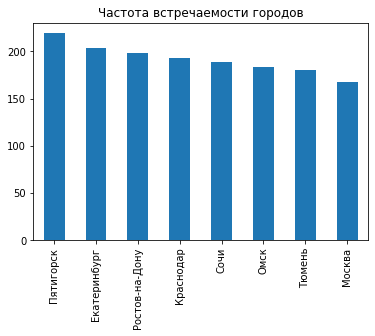

In [12]:
users_go['city'].value_counts().plot.bar(title='Частота встречаемости городов')
plt.show()

**Соотношение пользователей с подпиской и без подписки:**

subscription_type
free     835
ultra    699
Name: user_id, dtype: int64

Количество пользователей без подписки 54.4%
Количество пользователей с подпиской 45.6%


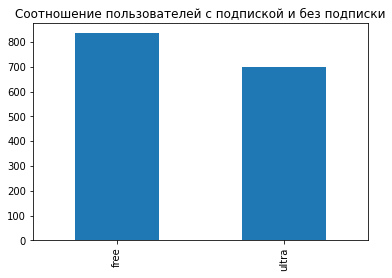

In [13]:
display(users_go.groupby('subscription_type')['user_id'].count())
free = users_go.loc[users_go['subscription_type'] == 'free', 'user_id'].count()/users_go['user_id'].count()
ultra = users_go.loc[users_go['subscription_type'] == 'ultra', 'user_id'].count()/users_go['user_id'].count()
print(f'Количество пользователей без подписки {free:.1%}')
print(f'Количество пользователей с подпиской {ultra:.1%}')
users_go['subscription_type'].value_counts().plot.bar(title='Соотношение пользователей с подпиской и без подписки')
plt.show()

Пользователей без подписки на 8,8 % больше, чем пользователей с подпиской.

**Возраст пользователей:**

In [15]:
users_go['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

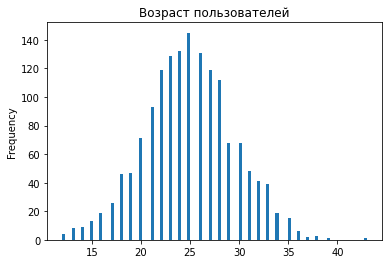

25    145
24    132
26    131
23    129
27    119
22    119
28    112
21     93
20     71
30     68
29     68
31     48
19     47
18     46
32     41
33     39
17     26
34     19
16     19
35     15
15     13
14      9
13      8
36      6
12      4
38      3
37      2
39      1
43      1
Name: age, dtype: int64

In [16]:
users_go['age'].plot(kind='hist', bins=100, title='Возраст пользователей')
plt.show()
users_go['age'].value_counts()

Наиболее часто сервисом пользуется группа людей возрастом от 20 до 30 лет (самый популярный возраст - 25 лет). Меньше всего сервисом пользуются люди до 15 и старше 36 лет.

**Расстояние, которое пользователь преодолел за одну поездку:**

In [17]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

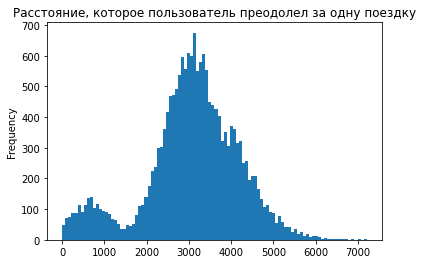

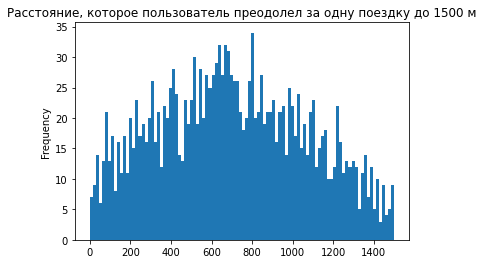

In [18]:
rides_go['distance'].plot(kind='hist', bins=100, title='Расстояние, которое пользователь преодолел за одну поездку')
plt.show()
rides_go['distance'].plot(kind='hist', bins=100, range=(0, 1500), title='Расстояние, которое пользователь преодолел за одну поездку до 1500 м')
plt.show()

Чаще всего пользователи пользуются самокатом на расстояние около 3100 метров. Далее идут нисходящие тренды 7211 и до около 1500 метров. Также есть пик на расстояние около 600 метров, возможно, люди пользуются самокатом в данном случае не для прогулки, а для того, чтобы добраться до метро. 

**Продолжительность поездок:**

In [19]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

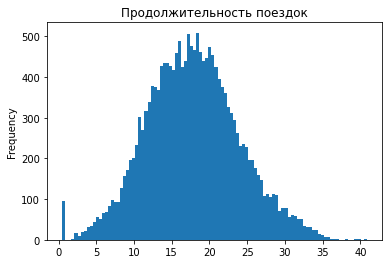

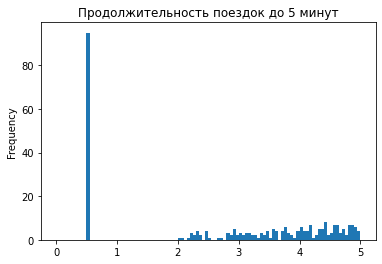

95

1364    2
1007    2
1243    2
973     2
1224    2
       ..
1317    1
804     1
931     1
1057    1
1176    1
Name: user_id, Length: 90, dtype: int64

In [20]:
rides_go['duration'].plot(kind='hist', bins=100, title='Продолжительность поездок')
plt.show()
rides_go['duration'].plot(kind='hist', bins=100, range=(0,5), title='Продолжительность поездок до 5 минут')
plt.show()
display(rides_go.loc[rides_go['duration'] == 0.5, 'user_id'].count())
rides_go_less_than_5_min = rides_go.loc[rides_go['duration'] == 0.5]
rides_go_less_than_5_min['user_id'].value_counts()

In [21]:
users_go.info()
rides_go.info()
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18068 non-null  int64         
 1   distance    18068 non-null  float64       
 2   duration    18068 non-null  float64       
 3   date        18068 non-null  datetime64[ns]
 4   date_month  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB

В основном, продолжительность поездки составляет около 18 минут. Однако встречается 95 случаев, когда продолжительность поездки составила пол минуты. У пользователей, оказавшихся в такой ситуации, это случалось не более 2 раз. Соответственно, можно предположить, что самокаты могли быть разряжены и пользователям приходилось завершать сессию по использованию. 

**Вывод:** 

**- всего в данных представлены пользователи из 8 городов. Наибольшее количество пользователей из Пятигорска, наименьшее - из Москвы;** 

**- количество пользователей без подписки равно 54.4%. Количество пользователей с подпиской составляет 45.6%;** 

**- наиболее часто сервисом пользуется группа людей возрастом от 20 до 30 лет (самый популярный возраст - 25 лет). Меньше всего сервисом пользуются люди до 15 и старше 36 лет;** 

**- чаще всего пользователи пользуются самокатом на расстояние около 3100 метров;**

**- в основном, продолжительность поездки составляет около 18 минут.**

#### Шаг 4. Объединение данных

**Создадим таблицу `users` из таблиц `users_go`, `subscriptions_go` и `rides_go`:**

In [22]:
users=pd.merge(users_go, subscriptions_go, how='outer', on='subscription_type')
users=pd.merge(rides_go, users, how='outer', on='user_id')
users.head()

,user_id,distance,duration,date,date_month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


**Создадим датафреймы для пользователей с подпиской и без:**

In [23]:
users_with_free = users.loc[users['subscription_type'] == 'free']
users_with_ultra = users.loc[users['subscription_type'] == 'ultra']

**Визуализация расстояния и времени поездок для пользователей с подпиской и без:**

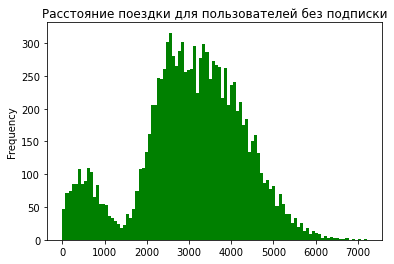

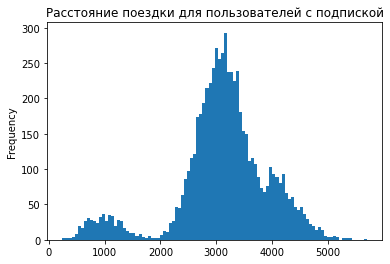

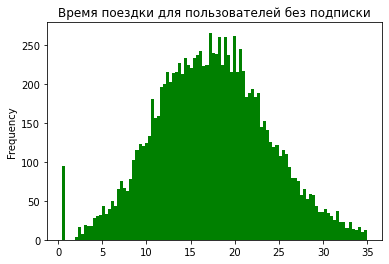

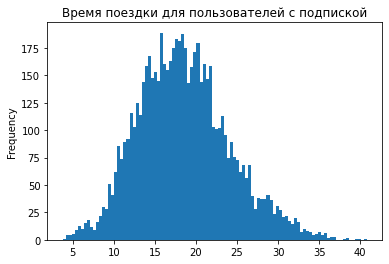

In [25]:
users_with_free['distance'].plot(kind='hist', bins=100, color='g', title='Расстояние поездки для пользователей без подписки')
plt.show()

users_with_ultra['distance'].plot(kind='hist', bins=100, title='Расстояние поездки для пользователей с подпиской')
plt.show()

users_with_free['duration'].plot(kind='hist', bins=100, color='g', title='Время поездки для пользователей без подписки')
plt.show()

users_with_ultra['duration'].plot(kind='hist', bins=100, title='Время поездки для пользователей с подпиской')
plt.show()

In [26]:
users_with_free['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [27]:
users_with_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [28]:
users_with_free['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [29]:
users_with_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

**Вывод: в среднем, люди с подпиской проезжают на 70 метров больше, чем люди без подписки. Среднее и медианное время пользования для них также незначительно больше. Пользователи, воспользовавшиеся услугами пол минуты, оказались люди без подписки. Так что, предположение, сделанное ранее о том, что самокаты были разряжены, может быть неверным. Вероятнее всего, они не ознакомились с условиями пользования и, узнав, что с них сразу списалось 50 рублей, подумали, что так будет каждую минуту и решили завершить поездки.**

#### Шаг 5. Подсчёт выручки

**Сводная таблица по месяцам для каждого пользователя по суммарному расстоянию, суммарному времени, суммарному количеству поездок:**

In [30]:
users['duration'] = np.ceil(users['duration']) 
users_for_1_month = users.pivot_table(index=['user_id', 'date_month'], values = ['distance', 'duration', 'city'],
                                      aggfunc={'distance':'sum', 'duration':'sum', 'city':'count'}).reset_index()
users_for_1_month.info()
users_for_1_month.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     11331 non-null  int64  
 1   date_month  11331 non-null  int64  
 2   city        11331 non-null  int64  
 3   distance    11331 non-null  float64
 4   duration    11331 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 442.7 KB


,user_id,date_month,city,distance,duration
0,1,1,2,7027.511294,42.0
1,1,4,1,754.159807,7.0
2,1,8,2,6723.470560,46.0
3,1,10,2,5809.911100,32.0
4,1,11,3,7003.499363,56.0
5,1,12,2,6751.629942,28.0
6,2,3,3,10187.723006,63.0
7,2,4,2,6164.381824,40.0
8,2,6,1,3255.338202,14.0
9,2,7,2,6780.722964,48.0


**Сводная таблица по месяцам для каждого пользователя по суммарному расстоянию, суммарному времени, суммарному количеству поездок c добавленными данными о подписке и стоимостях:**

In [31]:
one_month_revenue = users[['user_id', 'date_month','subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']]
users_for_1_month_revenue = users_for_1_month.merge(one_month_revenue, how='left', on=['date_month', 'user_id'])

users_for_1_month_revenue = users_for_1_month_revenue.drop_duplicates().reset_index(drop=True)
users_for_1_month_revenue.info()
users_for_1_month_revenue.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11331 non-null  int64  
 1   date_month         11331 non-null  int64  
 2   city               11331 non-null  int64  
 3   distance           11331 non-null  float64
 4   duration           11331 non-null  float64
 5   subscription_type  11331 non-null  object 
 6   minute_price       11331 non-null  int64  
 7   start_ride_price   11331 non-null  int64  
 8   subscription_fee   11331 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 796.8+ KB


,user_id,date_month,city,distance,duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,ultra,6,0,199
1,1,4,1,754.159807,7.0,ultra,6,0,199
2,1,8,2,6723.470560,46.0,ultra,6,0,199
3,1,10,2,5809.911100,32.0,ultra,6,0,199
4,1,11,3,7003.499363,56.0,ultra,6,0,199


**Добавление столбца с выручкой:**

In [32]:
users_for_1_month_revenue['revenue'] = (users_for_1_month_revenue['subscription_fee'] 
                                        + users_for_1_month_revenue['start_ride_price']*users_for_1_month_revenue['city'] 
                                        + users_for_1_month_revenue['minute_price']*users_for_1_month_revenue['duration'])
display(users_for_1_month_revenue.head())
display(users_for_1_month_revenue.tail())
users_for_1_month_revenue.groupby('subscription_type')['revenue'].sum()


,user_id,date_month,city,distance,duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,2,7027.511294,42.0,ultra,6,0,199,451.0
1,1,4,1,754.159807,7.0,ultra,6,0,199,241.0
2,1,8,2,6723.470560,46.0,ultra,6,0,199,475.0
3,1,10,2,5809.911100,32.0,ultra,6,0,199,391.0
4,1,11,3,7003.499363,56.0,ultra,6,0,199,535.0


,user_id,date_month,city,distance,duration,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
11326,1534,6,2,3409.468534,26.0,free,8,50,0,308.0
11327,1534,8,2,7622.453034,48.0,free,8,50,0,484.0
11328,1534,9,1,4928.173852,23.0,free,8,50,0,234.0
11329,1534,11,4,13350.015305,78.0,free,8,50,0,824.0
11330,1534,12,1,2371.711192,16.0,free,8,50,0,178.0


subscription_type
free     2234104.0
ultra    1644537.0
Name: revenue, dtype: float64

#### Шаг 6. Проверка гипотез

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

`Нулевая гипотеза`: средние значения времени на поездки пользователей из двух групп равны.

`Альтернативная гипотеза`: время поездок пользователей с подпиской больше, чем время поездок пользователей без подписки.

In [34]:
alpha = 0.05
result = st.ttest_ind(users_with_ultra['duration'], users_with_free['duration'], equal_var=False, alternative='greater')
print(f'p-value: {result.pvalue}')
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


**Значение p-value меньше заданного уровня значимости. Есть основание говорить, что время поездок пользователей с подпиской больше, чем время поездок пользователей без подписки.**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

`Нулевая гипотеза`: средние расстояние одной поездки людей с подпиской равно 3130 метров.

`Альтернативная гипотеза`: среднее расстояние одной поездки людей с подпиской меньше 3130 метров.

In [36]:
dist = users_with_ultra['distance']
ave_dist = 3130
alpha = 0.05
res = st.ttest_1samp(dist, ave_dist, alternative='greater')
print(f'p-value: {res.pvalue}')
if res.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


**Значение p-value больше заданного уровня значимости. Есть основание говорить, что среднее расстояние поездок людей с подпиской равно 3130 метрам, что не приводит к износу самокатов.**

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

`Нулевая гипотеза`: выручка от пользователей с подпиской и без равна.

`Альтернативная гипотеза`: выручка от пользователей с подпиской больше, чем от людей без подписки.

**Разделим таблицу с выручкой на 2 части, в зависимости от наличия подписки:**

In [37]:
users_for_1_month_revenue_with_free = users_for_1_month_revenue.loc[users_for_1_month_revenue['subscription_type'] == 'free'].reset_index(drop=True)
users_for_1_month_revenue_with_ultra = users_for_1_month_revenue.loc[users_for_1_month_revenue['subscription_type'] == 'ultra'].reset_index(drop=True)

In [38]:
alpha = 0.05
result = st.ttest_ind(users_for_1_month_revenue_with_ultra['revenue'], users_for_1_month_revenue_with_free['revenue'], equal_var=False, alternative='greater')
print(f'p-value: {result.pvalue}')
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


**Значение p-value меньше заданного уровня значимости. Есть основание говорить, что выручка от пользователей с подпиской больше, чем от людей без подписки.** 

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Нулевой гипотезой можно принять: количество обращений в техподдержку после обновления сервера осталось равно такому же количеству до обновления.
Альтернативная гипотеза: количество обращений в техподдержку после обновления сервера снизилось.
У нас есть две выборки, которые можно сравнить с помощью Т-теста, значение параметра equal_var сделать False, если выборки не равны по размеру, значение alternative сделать greater, если в st.ttest_ind на первое место поставить выборку до обновления сервера.
Затем необходимо сравнить p-value с заданным урвонем значимости.**

**Вывод: Есть основание говорить, что время поездок пользователей с подпиской больше, чем время поездок пользователей без подписки. Есть основание говорить, что среднее расстояние поездок людей с подпиской равно 3130 метрам, что не приводит к износу самокатов. Есть основание говорить, что выручка от пользователей с подпиской больше, чем от людей без подписки.**

#### Шаг 7. Распределения (необязательное задание)

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соотвествующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

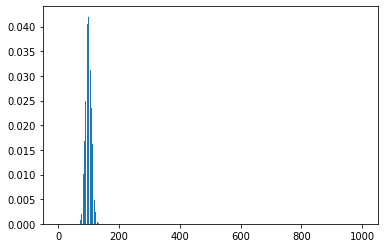

84

In [39]:
n = 1000 # количество попыток
p = 0.1 # вероятность успеха

distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr.append(prob)

plt.bar(range(0, n + 1), distr)
plt.show()

mu = n * p
sigma = sqrt(n * p * (1 - p))
distr = st.norm(mu, sigma) 

percent=[]

for m in range(1000):
    if distr.cdf(m)<0.05:
        percent.append(m)

percent = pd.Series(percent)
percent.max()

**Минимальное количество промокодов, которые нужно разослать, чтобы вероятность не выполнить план была примерно 5 %, равно 84.**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [40]:
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma) 

# считаем вероятность хвоста слева от 399,5 тысяч
result = distr.cdf(399500)
print(f'Вероятность того, что уведомление откроют не более 399,5 тыс. человек составляет {result:.1%}')

Вероятность того, что уведомление откроют не более 399,5 тыс. человек составляет 15.4%


**Общие выводы:**
1) После знакомства с данными было выявлено, что во всех исходных таблицах отсутствуют пропущенные значения. Все типы данных подходящие, кроме столбца `date` в таблице `rides_go`. К наименованиям столбцов вопросов нет.

2) В результате предобработки данных был изменен тип данных для столбца `date`. Добавлена колонка в таблицу с номером месяца. Устранены явные дубликаты.

3) Всего в данных представлены пользователи из 8 городов. Количество пользователей без подписки равно 54.4 %. Количество пользователей с подпиской составляет 45.6 %. Наиболее часто сервисом пользуется группа людей возрастом от 20 до 30 лет. Чаще всего пользователи пользуются самокатом на расстояние около 3100 метров, а продолжительность поездки составляет около 18 минут.

4) После подсчета выручки стало известно, что пользователи без подписки принесли компании `2234104` рублей, а пользователи с подпиской `1644537` рублей.

5) Есть основание говорить, что время поездок пользователей с подпиской больше, чем время поездок пользователей без подписки. Есть основание говорить, что среднее расстояние поездок людей с подпиской равно 3130 метрам, что не приводит к износу самокатов. Есть основание говорить, что выручка от пользователей с подпиской больше, чем от людей без подписки. Это подтверждается и в п.4, поскольку люди без подписки осуществили около 64 % от всех поездок, а выручка от составляет менее 58 % от общей.

**Рекомендации:**
1) Направлять рекламные компании на людей до 20 и старше 30 лет, поскольку они мало вовлечены в использование сервиса.

2) Рассмотреть возможность предоставлять скидки после 30 минуты поездки, поскольку далее время пользования значительно снижается, но необходимо учитывать амортизацию самоката.

3) Создавать промоакции для того, чтобы как можно больше людей приобретали подписку, поскольку они приносят больше выручки.